<a href="https://colab.research.google.com/github/Soomin-Maxwell/Medical_AI_study/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.9MB 2.8MB/s 


## Download Datasets

In [11]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [13]:
import tensorflow_datasets as tfds 
tfds.disable_progress_bar()

from IPython.display import clear_output 
import matplotlib.pyplot as plt

In [14]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info = True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Expansion & Normalization 

In [15]:
def normalize(input_image, input_mask) :
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [24]:
@tf.function 
def load_image_train(datapoint) :
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128,128))

    if tf.random.uniform(()) > 0.5 : 
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [29]:
def load_image_test(datapoint) :
  input_image = tf.image.resize(datapoint['image'], (128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [30]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [31]:
train = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE )
test = dataset["test"].map(load_image_test)

In [35]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [40]:
def display(display_list) :
  plt.figure(figsize = (15,15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)) :
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis("off")

  plt.show()

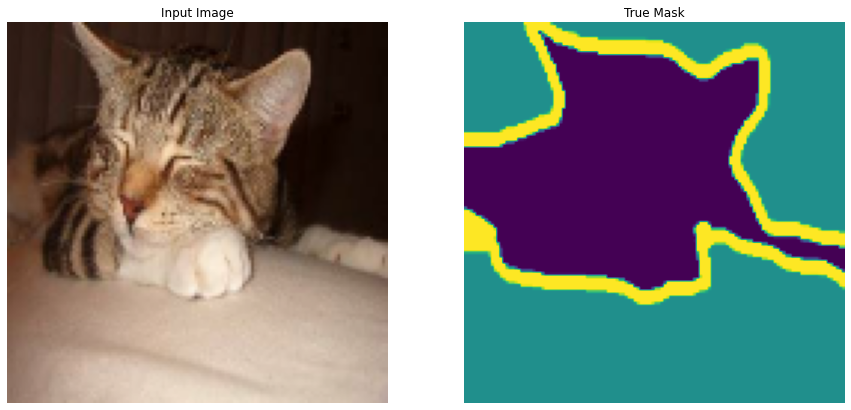

In [43]:
for image,mask in train.take(10) :
  sample_image, sample_mask = image,mask
display([sample_image, sample_mask])

## 모델 정의하기

U-net : 인코더 (다운 샘플러) -> 미리 훈련된 것으로 구현 가능 <br/>
        디코더 (업샘플러)

In [44]:
OUTPUT_CHANNELS = 3

In [46]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top = False)


# 층 활성화 
layer_names = [
      "block_1_expand_relu",  # 64*64 
      "block_3_expand_relu",  # 32*32 
      "block_6_expand_relu",  # 16*16
      "block_13_expand_relu", # 8*8
      "block_16_project",     # 4*4 
]

layers = [base_model.get_layer(name).output for name in layer_names]

# 특징 추출 모델 
down_stack = tf.keras.Model(inputs= base_model.input, outputs= layers)
down_stack.trainable = False



9412608/9406464 [==============================] - 0s 0us/step


In [47]:
up_stack = [
      pix2pix.upsample(512,3) , 
      pix2pix.upsample(256,3),
      pix2pix.upsample(128,3),
      pix2pix.upsample(64,3)
      ]

In [56]:
def unet_model(output_channels) :
  inputs = tf.keras.layers.Input(shape = [128,128,3])
  x = inputs

  # 모델을 통해 다운샘플링을 해 보자 
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하기
  for up,skip in zip(up_stack,skips) :
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x,skip])

  # 마지막 층 
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides =2,
      padding= "same"
  ) 

  x = last(x)

  return tf.keras.Model(inputs = inputs,outputs=x)

In [58]:
model = unet_model (OUTPUT_CHANNELS)
model.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ["accuracy"])

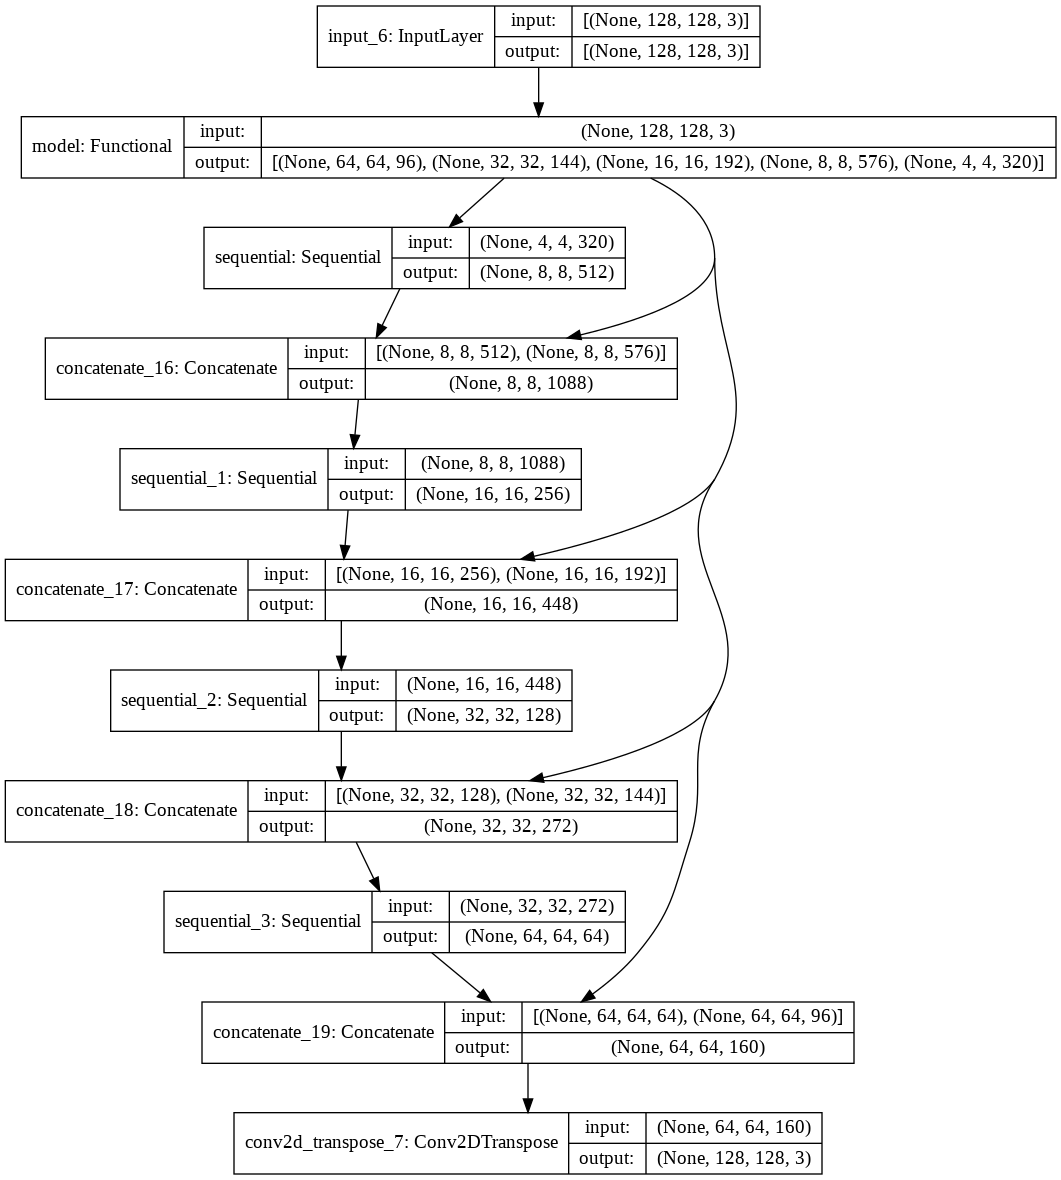

In [59]:
tf.keras.utils.plot_model(model, show_shapes =True)

In [60]:
def create_mask(pred_mask) :
  pred_mask = tf.armax(pred_mask, axis = -1)
  pred_mask = pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset = None, num=1) :
  if dataset : 
    for image,mask in dataset.take(num) :
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

      